Today we use principal component analysis to explore Spotify data for songs written between 1950 and 2010. The data are in separate files (called 1950.csv, 1960.csv, etc) for each decade; we start by combining them into a single data frame.

In [2]:
import pandas as pd

data_frames = {}
for i in range(1950,2011,10):
    data_frames[i] = pd.read_csv(str(i)+'.csv')
    data_frames[i] = data_frames[i].drop(['Number'],axis=1)

songs = pd.concat([data_frames[i]  \
    for i in range(1950,2011,10)])
print(songs.head())

                                               title               artist  \
0                       Put Your Head On My Shoulder            Paul Anka   
1  Whatever Will Be Will Be (Que Sera Sera) (with...            Doris Day   
2                           Everybody Loves Somebody          Dean Martin   
3        Take Good Care Of My Baby - 1990 Remastered            Bobby Vee   
4                                 A Teenager In Love  Dion & The Belmonts   

         top genre  year  bpm  nrgy  dnce  dB  live  val  dur  acous  spch  \
0  adult standards  2000  116    34    55  -9    10   47  155     75     3   
1  adult standards  1948  177    34    42 -11    72   78  123     86     4   
2  adult standards  2013   81    49    26  -9    34   40  162     81     4   
3  adult standards  2011   82    43    49 -12    12   66  151     70     6   
4  adult standards  1959   79    38    56  -9    13   62  158     67     3   

   pop  
0   72  
1   62  
2   61  
3   60  
4   60  


The fields with unobvious meanings are: bpm = beats per minute; nrgy = energy level; dnce = danceability; dB = loudness; live = liveness (with a higher number meaning higher a likelihood of the recording being live); val = valence (with a higher number corresponding to a higher positive mood); dur = duration; acous = acousticness; spch = speechiness (higher means more spoken words); pop = popularity.

We extract the numerical fields and see how many principal components we need to explain various percentages of the data.

Text(0, 0.5, 'cumulative explained variance')

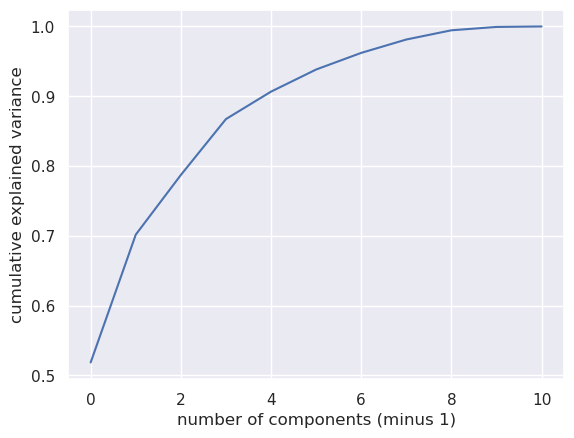

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

songs = pd.read_csv('all_years.csv')
pca = PCA()

X = songs.drop(['title','artist','top genre'],axis=1)

%matplotlib inline
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components (minus 1)')
plt.ylabel('cumulative explained variance')

We see that about 70% of the data can be explained by two principal components (note that the first component is labeled "0"). Let's express the data in terms of these component directions and group the result by genre.

In [6]:
pca = PCA(0.70)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X))
X_pca['genre'] = songs['top genre']
genre_pca = X_pca.groupby(by=['genre']).mean()
print(genre_pca.head())

                          0          1
genre                                 
acoustic blues    65.129148 -10.982230
adult standards  -45.261659  30.869426
afrobeat         -64.351904 -26.235664
afropop          178.522942  64.016836
album rock        33.228259  -4.024576


So, for example, acoustic blues and afropop load high on principal component zero while, of these two, only afropop loads high on principal component one. We can see how these values relate to, say danceability, with a scatter plot.

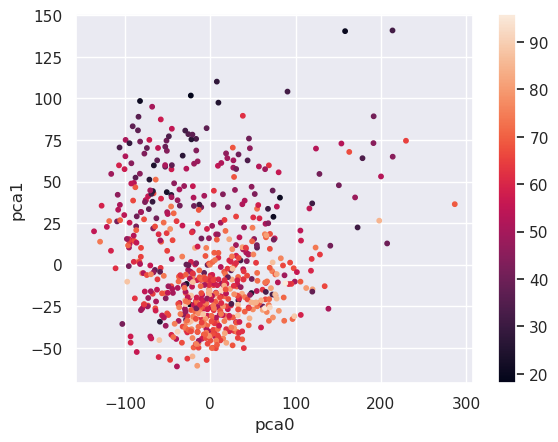

In [7]:
plt.scatter(X_pca.iloc[:,0],X_pca.iloc[:,1],s=10, \
            c=songs['dnce'])
plt.xlabel('pca0')
plt.ylabel('pca1')
plt.colorbar()

The more danceable genres tend to load low on principal component 1. We can see which genres are the most and least danceable by querying the data:

In [14]:
high_dnce = (genre_pca[1]<0)
genre_pca[high_dnce].head()

,0,1
genre,,
acoustic blues,65.129148,-10.982230
afrobeat,-64.351904,-26.235664
album rock,33.228259,-4.024576
alternative metal,1.633728,-31.132024
alternative r&b,-15.708144,-22.355832


In [28]:
low_dnce = (genre_pca[1]>50.0)
genre_pca[low_dnce].head()

,0,1
genre,,
afropop,178.522942,64.016836
avant-garde jazz,213.712463,140.855648
bebop,160.565217,104.111861
blues,229.492590,74.519282
british folk,-18.102521,61.018127


Let's repeat the same steps for popularity:

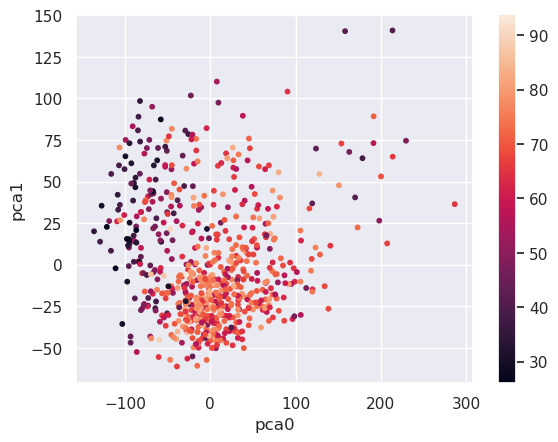

In [17]:
plt.scatter(X_pca.iloc[:,0],X_pca.iloc[:,1],s=10, \
            c=songs['pop'])
plt.xlabel('pca0')
plt.ylabel('pca1')
plt.colorbar()

In [26]:
most_pop = (genre_pca[0]>-50) & (genre_pca[0]<100)
genre_pca[most_pop].head()

,0,1
genre,,
acoustic blues,65.129148,-10.982230
adult standards,-45.261659,30.869426
album rock,33.228259,-4.024576
alternative country,-40.116761,33.310572
alternative metal,1.633728,-31.132024


In [27]:
least_pop = (genre_pca[0]>-150) & (genre_pca[0]<-50)
genre_pca[least_pop].head()

,0,1
genre,,
afrobeat,-64.351904,-26.235664
american folk revival,-64.653072,22.946793
appalachian folk,-70.237852,-0.487309
australian rock,-58.740034,-4.316319
australian talent show,-103.017823,-35.674851


Of course we could have found out the same things by querying the original data. The main point of these scatter plots is to build a bridge between the data expressed in pca coordinates and the original features, to make the pca coordinates more interpretable. And the main strength of principal component analysis is that we can filter out noise or make an otherwise computationally prohibitive problem much more tractible by lowering the number of features a model would have to deal with.